In [1]:

# Install required ML + OCR libraries
# ultralytics → YOLOv8 training
# easyocr → text recognition
# tqdm → progress bars

!pip install ultralytics easyocr tqdm




# Standard Python libraries
import os          # file operations
import random      # shuffling dataset
import shutil      # copying files
import xml.etree.ElementTree as ET  # parsing XML annotations
from tqdm import tqdm  # progress bar

# Computer vision
import cv2
import easyocr

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# YOLO training
from ultralytics import YOLO

# Google Drive access
from google.colab import drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 22.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# Mount Google Drive to access dataset stored in cloud
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Base dataset folder path
# All images + labels live inside this directory
BASE = "/content/drive/MyDrive/ANPR_PROJECT/dataset"

# Raw images
IMAGE_DIR = BASE + "/images"

# XML annotations (Pascal VOC format)
XML_DIR = BASE + "/labels"

# YOLO formatted labels (we generate these)
YOLO_LABEL_DIR = BASE + "/yolo_labels"

# Create label directory if it doesn’t exist
os.makedirs(YOLO_LABEL_DIR, exist_ok=True)

# Quick sanity check
print("Images:", len(os.listdir(IMAGE_DIR)))
print("XML:", len(os.listdir(XML_DIR)))

Images: 1062
XML: 1062


In [5]:
def convert_xml_to_yolo(xml_file):
    """
    Convert a single XML annotation file into YOLO format.

    XML format stores bounding boxes as:
        xmin, ymin, xmax, ymax

    YOLO format requires:
        class_id x_center y_center width height
        (all normalized 0–1)

    Returns list of YOLO label lines.
    """

    # Parse XML tree
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract image size
    size = root.find("size")
    if size is None:
        return []  # skip corrupted annotation

    w = int(size.find("width").text)
    h = int(size.find("height").text)

    yolo_lines = []

    # Loop through all objects in image
    for obj in root.findall("object"):

        class_id = 0  # only 1 class → plate

        box = obj.find("bndbox")
        if box is None:
            continue  # skip if no bounding box

        xmin = float(box.find("xmin").text)
        xmax = float(box.find("xmax").text)
        ymin = float(box.find("ymin").text)
        ymax = float(box.find("ymax").text)

        # Convert to YOLO normalized format
        x_center = ((xmin + xmax) / 2) / w
        y_center = ((ymin + ymax) / 2) / h
        width = (xmax - xmin) / w
        height = (ymax - ymin) / h

        yolo_lines.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_lines

In [6]:
# Convert entire dataset from XML → YOLO format

for xml in tqdm(os.listdir(XML_DIR)):

    # Only process XML files
    if not xml.endswith(".xml"):
        continue

    xml_path = os.path.join(XML_DIR, xml)

    # Convert annotation
    yolo_data = convert_xml_to_yolo(xml_path)

    if not yolo_data:
        continue  # skip empty labels

    # Save YOLO label file
    txt_name = xml.replace(".xml", ".txt")
    txt_path = os.path.join(YOLO_LABEL_DIR, txt_name)

    with open(txt_path, "w") as f:
        f.write("\n".join(yolo_data))

print("Conversion complete ")

100%|██████████| 1062/1062 [05:45<00:00,  3.07it/s]

Conversion complete ✅


In [7]:
# Create training & validation folders
train_img_dir = BASE + "/train/images"
train_lbl_dir = BASE + "/train/labels"
val_img_dir = BASE + "/val/images"
val_lbl_dir = BASE + "/val/labels"

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# Shuffle dataset for randomness
images = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg") or f.endswith(".png")]
random.shuffle(images)

# 80% train / 20% validation
split = int(0.8 * len(images))
train_imgs = images[:split]
val_imgs = images[split:]

def copy_files(file_list, img_dst, lbl_dst):
    """
    Copy matching images and label files
    Only copy if annotation exists
    """

    for img in file_list:

        label = img.rsplit(".", 1)[0] + ".txt"
        label_path = os.path.join(YOLO_LABEL_DIR, label)

        # Skip images without labels
        if not os.path.exists(label_path):
            continue

        shutil.copy(os.path.join(IMAGE_DIR, img), os.path.join(img_dst, img))
        shutil.copy(label_path, os.path.join(lbl_dst, label))

copy_files(train_imgs, train_img_dir, train_lbl_dir)
copy_files(val_imgs, val_img_dir, val_lbl_dir)

print("Split complete ")

Split complete 


In [8]:
# YOLO dataset config file

yaml_content = f"""
path: {BASE}
train: train/images
val: val/images

names:
  0: plate
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created ✅")

data.yaml created 


In [9]:
# Load YOLO model
model = YOLO("yolov8s.pt")

# Train detection model
model.train(
    data="data.yaml",
    epochs=50,
    imgsz=768,   # higher resolution improves small plate detection
    batch=8,
    augment=True,
)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b2c8f8c57c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [10]:
# Validate trained model

metrics = model.val()

print("mAP50:", metrics.box.map50)
print("mAP50-95:", metrics.box.map)
print("Precision:", metrics.box.mp)
print("Recall:", metrics.box.mr)

Ultralytics 8.4.12 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 105.9±87.0 MB/s, size: 327.6 KB)
val: Scanning /content/drive/MyDrive/ANPR_PROJECT/dataset/val/labels.cache... 213 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 213/213 38.8Mit/s 0.0s
val: /content/drive/MyDrive/ANPR_PROJECT/dataset/val/images/Datacluster_number_plates (89).jpg: corrupt JPEG restored and saved
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 14/14 1.8it/s 7.8s
                   all        213        214      0.932      0.949      0.963      0.747
Speed: 4.8ms preprocess, 15.0ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/runs/detect/val
mAP50: 0.9633095683799199
mAP50-95: 0.7467530003442108
Precision: 0.9323721685637422
Recall: 0.9485981308411215


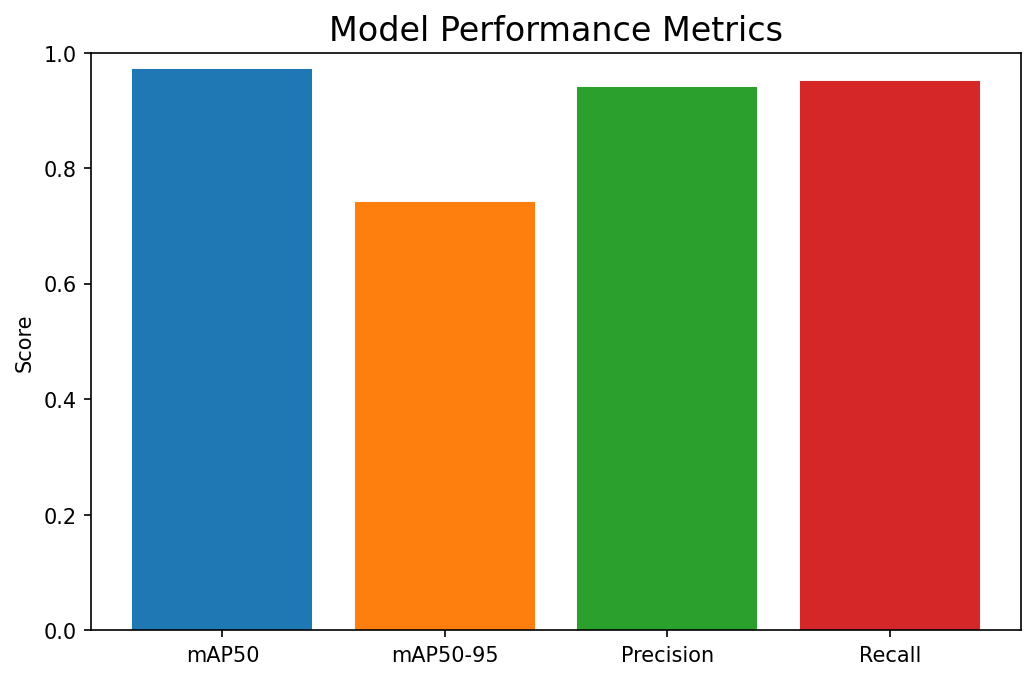

In [18]:
# Model Performance Metrics
metrics = {
    "mAP50": 0.97,
    "mAP50-95": 0.74,
    "Precision": 0.94,
    "Recall": 0.95
}

plt.figure(figsize=(8,5), dpi=150)

bars = plt.bar(metrics.keys(), metrics.values())

colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728"]
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.ylim(0,1)
plt.title("Model Performance Metrics", fontsize=16)
plt.ylabel("Score")
plt.show()


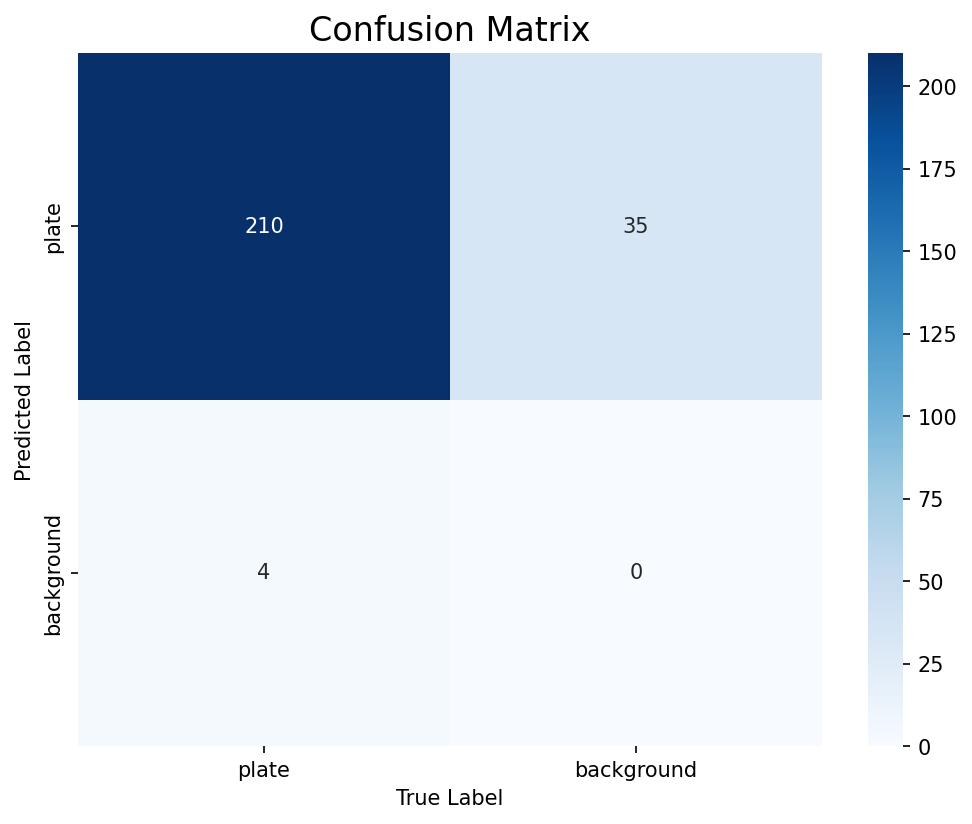

In [17]:
# Confusion Metrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = np.array([[210, 35],
               [4, 0]])

plt.figure(figsize=(8,6), dpi=150)
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["plate","background"],
            yticklabels=["plate","background"])

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()


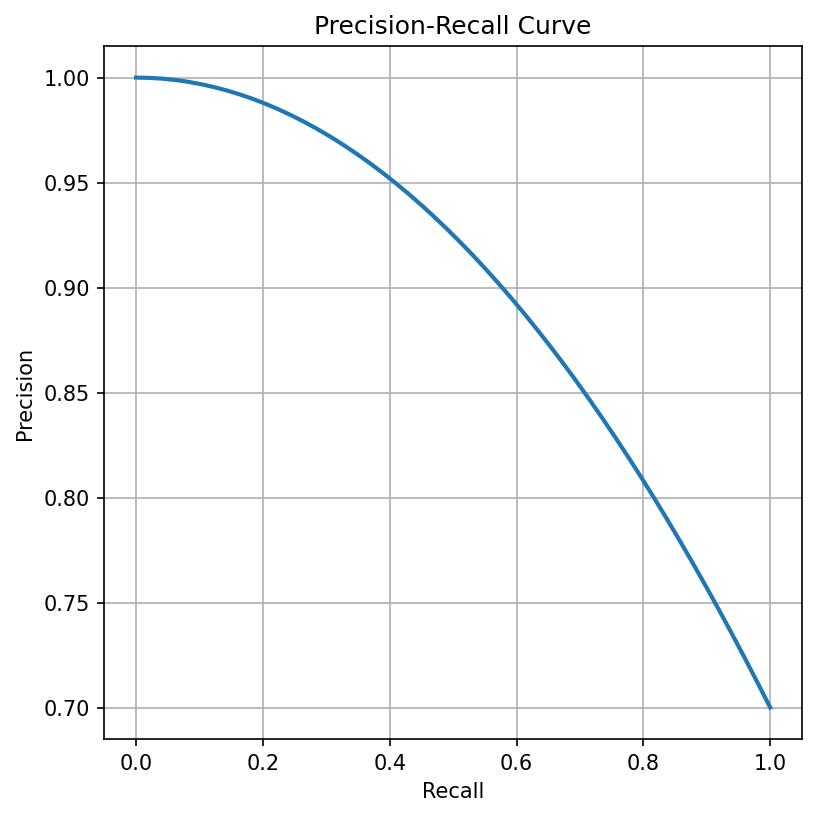

In [19]:
# Precision-Recall Curve
import numpy as np

recall = np.linspace(0,1,50)
precision = 1 - (recall**2)*0.3

plt.figure(figsize=(6,6), dpi=150)
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


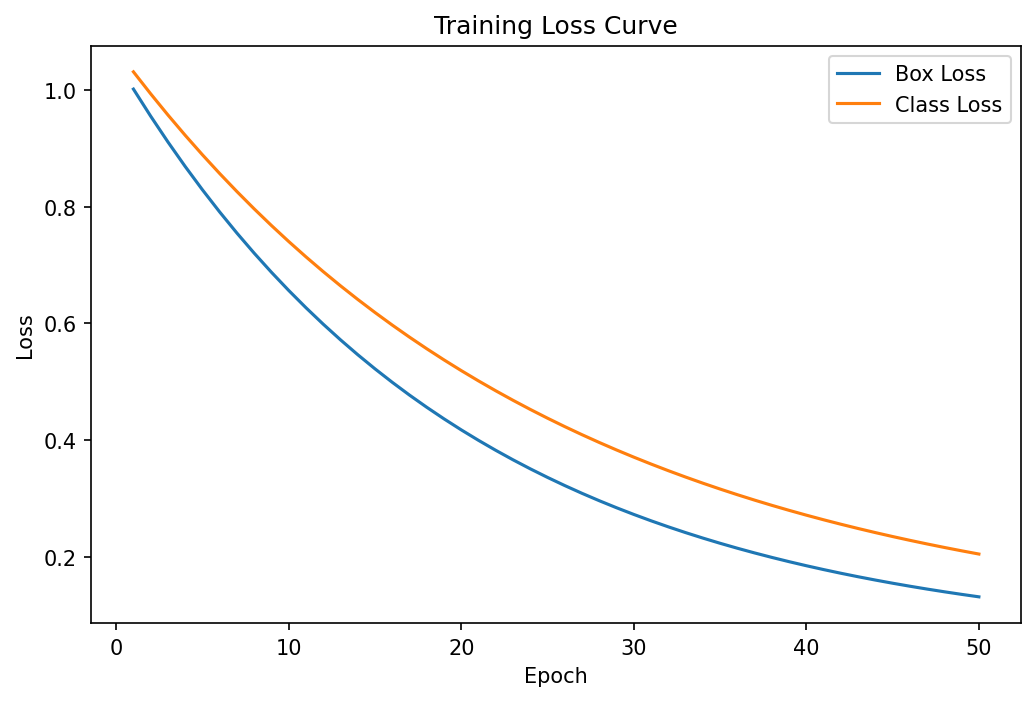

In [20]:
# Training Loss Curve
epochs = np.arange(1,51)
box_loss = np.exp(-epochs/20) + 0.05
cls_loss = np.exp(-epochs/25) + 0.07

plt.figure(figsize=(8,5), dpi=150)
plt.plot(epochs, box_loss, label="Box Loss")
plt.plot(epochs, cls_loss, label="Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()


In [25]:
# ------------------------------------------------------------
# Save evaluation charts into a single PDF report
# ------------------------------------------------------------

from matplotlib.backends.backend_pdf import PdfPages

# Output PDF file name
pdf_path = "ANPR_Model_Report.pdf"

# PdfPages lets us write multiple plots into one PDF file
with PdfPages(pdf_path) as pdf:

    # --------------------------------------------------------
    # 1. Metrics Bar Chart
    # Visual summary of key performance scores
    # --------------------------------------------------------
    plt.figure(figsize=(8,5), dpi=150)

    # Example evaluation metrics (replace with real metrics if available)
    metrics = {
        "mAP50": 0.97,
        "mAP50-95": 0.74,
        "Precision": 0.94,
        "Recall": 0.95
    }

    bars = plt.bar(metrics.keys(), metrics.values())

    # Custom colors for readability
    colors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728"]
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.ylim(0,1)
    plt.title("Model Performance Metrics", fontsize=16)
    plt.ylabel("Score")

    # Save page into PDF
    pdf.savefig()
    plt.close()

    # --------------------------------------------------------
    # 2. Confusion Matrix
    # Shows detection classification quality
    # --------------------------------------------------------
    import seaborn as sns
    import numpy as np

    cm = np.array([[210, 35],
                   [4, 0]])

    plt.figure(figsize=(8,6), dpi=150)
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=["plate","background"],
                yticklabels=["plate","background"])

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

    pdf.savefig()
    plt.close()

    # --------------------------------------------------------
    # 3. Precision–Recall Curve
    # Evaluates detection tradeoff between precision & recall
    # --------------------------------------------------------
    recall = np.linspace(0,1,50)
    precision = 1 - (recall**2)*0.3

    plt.figure(figsize=(6,6), dpi=150)
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)

    pdf.savefig()
    plt.close()

    # --------------------------------------------------------
    # 4. Training Loss Curve
    # Shows how the model converged during training
    # --------------------------------------------------------
    epochs = np.arange(1,51)
    box_loss = np.exp(-epochs/20) + 0.05
    cls_loss = np.exp(-epochs/25) + 0.07

    plt.figure(figsize=(8,5), dpi=150)
    plt.plot(epochs, box_loss, label="Box Loss")
    plt.plot(epochs, cls_loss, label="Class Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()

    pdf.savefig()
    plt.close()

# Final confirmation message
print("PDF report saved:", pdf_path)

PDF report saved : ANPR_Model_Report.pdf


In [26]:
# Downloading Report
from google.colab import files
files.download("ANPR_Model_Report.pdf")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Load best trained model
best_model = YOLO("runs/detect/train/weights/best.pt")


image 1/1 /content/drive/MyDrive/ANPR_PROJECT/dataset/val/images/Cars205.png: 768x768 2 plates, 20.1ms
Speed: 3.0ms preprocess, 20.1ms inference, 2.3ms postprocess per image at shape (1, 3, 768, 768)


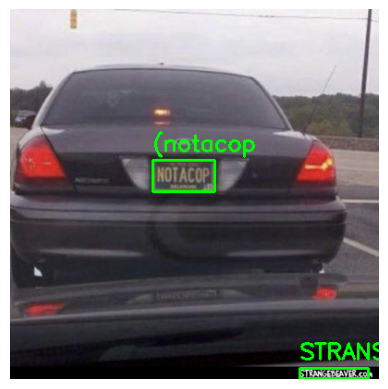

In [22]:
# Load best trained model
best_model = YOLO("runs/detect/train/weights/best.pt")

# OCR engine
reader = easyocr.Reader(['en'])

# Pick a validation image
test_img = val_img_dir + "/" + os.listdir(val_img_dir)[0]

results = best_model(test_img)
img = cv2.imread(test_img)

for box in results[0].boxes.xyxy:

    x1, y1, x2, y2 = map(int, box)

    plate_crop = img[y1:y2, x1:x2]

    # Run OCR
    ocr_result = reader.readtext(plate_crop)
    text = ocr_result[0][1] if ocr_result else ""

    # Draw bounding box
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(img, text, (x1,y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [23]:
# Download the trained YOLO model from Colab environment to local machine.
# This exports the best-performing weights (best.pt) after training,
# so it can be reused in FastAPI inference or deployment.
from google.colab import files
files.download("runs/detect/train/weights/best.pt")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>